<a href="https://colab.research.google.com/github/sid521/ML8-ImageCaptioning/blob/main/prediction_beam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cdist
import matplotlib.image as mpimg
import os
import tensorflow as tf
import cv2
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU,Reshape, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import categorical_accuracy,top_k_categorical_accuracy
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
import collections
import random
import json
from PIL import Image

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Load Resnet50

In [ ]:
image_features_extract_model = load_model('/content/resnet50_model.hdf5')

In [ ]:
image_features_extract_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
with open('/content/tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224)) # (224,224) is the default input of resnet50
    img = tf.keras.applications.resnet50.preprocess_input(img)
    print(img.shape)
    return img, image_path

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
# Shape of the vector extracted from resnet50 is (49, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 49

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 49, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 49, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 49, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 49, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # This encoder passes those features extracted from resnet50 (49,2048)through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc1 = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc1(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.gru2 = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(self.units)
    self.fc3 = tf.keras.layers.Dense(vocab_size)
    self.drop = tf.keras.layers.Dropout(0.25)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    x= self.drop(x)

    # passing the concatenated vector to the GRU
    output, state = self.gru1(x)
    x = self.drop(output)
    output, state_ = self.gru2(x)
    x = self.drop(output)
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(x)
    x= self.drop(x)
    x = self.fc2(x)
    x= self.drop(x)
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    # output shape == (batch_size * max_length, vocab)
    x = self.fc3(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
len(tokenizer.word_index)
inp = tf.expand_dims([tokenizer.word_index['<start>']], 0)

In [ ]:
vocab_size=5001
encoder = CNN_Encoder(embedding_dim)
encoder(np.zeros((49,2048)))
encoder.built=True
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
hidden = decoder.reset_state(batch_size=1)
decoder(inp,np.zeros((49,256)),hidden)
decoder.built=True

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
encoder_path='/content/encoder_gru_stack_2_512_enc_1.h5'
decoder_path='/content/decoder_gru_stack_2_512_enc_1.h5'
encoder.load_weights(encoder_path)
decoder.load_weights(decoder_path)

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(
            dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.argmax(predictions, 1)[0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (7, 7))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

## Prediction

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
# the cosine similarity of a random image in the test dataset
def similarity_score(index=None,verbose = True,view_image=False):
  real_captions=[]
  if index== None or index>=len(img_name_test)  :
    rid = np.random.randint(0, len(img_name_test))
  else :
    rid = index
  image = img_name_test[rid]
  a=img_to_cap_vector[image]
  for cap in a:
    temp= ' '.join([tokenizer.index_word[i]
                            for i in cap if i not in [0]])
    temp=temp.replace('<start>',' ')
    temp=temp.replace('<end>',' ')
    real_captions.append(temp)
  result, attention_plot = evaluate(image)
  res = ' '.join(result)
  result = res.replace('<end>',' ')
  encodings=model.encode(real_captions)
  result_encoding = model.encode(result)
  similarity=1-cdist(encodings,[result_encoding],'cosine').mean()
  if verbose:
    print('mean cosine similarity between the 5 true captions and the predicted caption : ', similarity)
    print("true captions : ",real_captions)
    print('Prediction Caption:', result)
    if view_image:
      img = mpimg.imread(image)
      imgplot = plt.imshow(img)
  return similarity

In [ ]:
# mean cosine similarity of n random test images and their mean
def mean_similarity_n_images(n=10):
  similarities=[]
  randomlist = random.sample(range(0, len(img_name_test)), n)
  for i in randomlist:
    similarity = similarity_score(verbose=False)
    similarities.append(similarity)
  mean_similarity =sum( similarities)/len(similarities)
  print('mean cosine similarity of {} random images : '.format(n),mean_similarity)
  return similarities , mean_similarity

## Test your own images

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(
            dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

#         predicted_id_1 = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_id = tf.argmax(predictions, 1)[0].numpy()
#         print(tokenizer.index_word[predicted_id],tokenizer.index_word[predicted_id_1])
#         print(tf.argmax(predictions, 1)[:5].numpy().shape)
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def beam_search_predictions(image, beam_index=2):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    start = [tokenizer.word_index["<start>"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
#         hidden = decoder.reset_state(batch_size=1)
        for s in start_word:
            dec_input = tf.expand_dims([s[0][-1]],1)
            print(dec_input)
            preds, hidden, attention_weights = decoder(
                dec_input, features, hidden)

#             attention_plot[a] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
#             print('l1')
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
#                 print(prob)
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
#             print('l2')

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
#         print(len(start_word))

    start_word = start_word[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
def predict(path):
    # the cosine similarity of a random image in the test dataset
    filename = os.path.abspath(path)
    img = Image.open(path)
    result= beam_search_predictions(path,1)
#     res = ' '.join(result)
#     result = res.replace('<end>',' ')
    print('Prediction Caption:', result)
    img_ = mpimg.imread(filename)
    plt.imshow(img_)

(224, 224, 3)
tf.Tensor([[3]], shape=(1, 1), dtype=int32)
tf.Tensor([[2]], shape=(1, 1), dtype=int32)
tf.Tensor([[707]], shape=(1, 1), dtype=int32)
tf.Tensor([[9]], shape=(1, 1), dtype=int32)
tf.Tensor([[2]], shape=(1, 1), dtype=int32)
tf.Tensor([[50]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]]

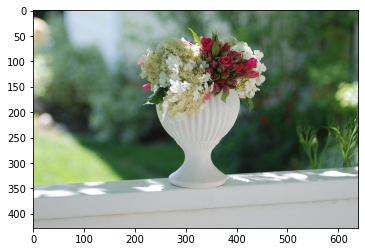

In [ ]:
path = 'test.jpg'
predict(path)

#Video Summarization

### Converting Video to frames

In [ ]:
import cv2
list=[]
# Opens the Video file
cap= cv2.VideoCapture('/content/samplevideo.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        total= i
        # 'total number of frames-1'  for the video
        print(total)
        break
    file_name_path = '/content/frames/frame' + str(i) + '.jpg' 
    list.append(file_name_path)   
    cv2.imwrite(file_name_path,frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

4106


In [ ]:
max_length=52
i=0
predics=[]
# empty list to append the predicted captions for all the frames
while i<total:
  image = list[i]
  result= beam_search_predictions(image,1)
  predics.append(result)
  #list where captions associated to all frames of video are stored 
  i=i+60
  #taking 1 frame out of every 60 frames
  #considering 1 frame for every 2 seconds

(224, 224, 3)
tf.Tensor([[3]], shape=(1, 1), dtype=int32)
tf.Tensor([[145]], shape=(1, 1), dtype=int32)
tf.Tensor([[146]], shape=(1, 1), dtype=int32)
tf.Tensor([[74]], shape=(1, 1), dtype=int32)
tf.Tensor([[8]], shape=(1, 1), dtype=int32)
tf.Tensor([[7]], shape=(1, 1), dtype=int32)
tf.Tensor([[3213]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[33]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[113]], shape=(1, 1), dtype=int32)
tf.Tensor([[2]], shape=(1, 1), dtype=int32)
tf.Tensor([[213]], shape=(1, 1), dtype=int32)
tf.Tensor([[8]], shape=(1, 1), dtype=int32)
tf.Tensor([[7]], shape=(1, 1), dtype=int32)
tf.Tensor([[3213]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[33]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[4]], shape=(1, 1), dtype=int32)
tf.Tensor([[113]], shape=(1, 1), dtype=int32)

In [ ]:
!pip install sentence-transformers

In [ ]:
#Remove one of the consecutive image caption greater than certain cosine similarity threshold between the two captions
# threshold value is 0.50
import math
i=0
n=math.floor((total/60)+1)
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
while i<n-1:
  sentences=[]
  sentences.append(predics[i])
  if len(predics)>=i+1:
    break
  else:  
    sentences.append(predics[i+1])
  model=SentenceTransformer('bert-base-nli-mean-tokens')
  sentence_embeddings=model.encode(sentences)
  #sentence_embeddings.shape
  cs=cosine_similarity([sentence_embeddings[0]],sentence_embeddings[1])
  if cs>0.50:
    del predics[i]
  else:
    i=i+1  


In [ ]:
#number of sentences removed by threshold
print(n-len(predics))

0


### Summarization with T5 base Transformer

In [ ]:
Text=" "
Text=Text+predics[0]
#concat all sentences in list and convert it into one paragraph
for i in range(1,int(n)):
  Text=Text+"."+predics[i]

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
# initialize the model architecture and weights
model = T5ForConditionalGeneration.from_pretrained("t5-base")
# initialize the model tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")

In [ ]:
#encode the text into tensor of integers using the appropriate tokenizer
inputs = t5_tokenizer.encode("summarize: " + Text, return_tensors="pt",truncation=True)

In [ ]:
# summary output generation in form of tokens
outputs = model.generate(
    inputs, 
    max_length=512, 
    min_length=50, 
    length_penalty=2.0, 
    num_beams=4, 
    early_stopping=True)
print(outputs)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


tensor([[   0, 2335, 3609,    3,    9, 4119,   11, 1131,   11,  872,   11,  872,
           11,  872,   11,  872,   11,  872,   11,  872,   11,  872,   11,  872,
           11,  872,   11,  872,   11,  872,   11,  872,   11,  872,   11,  872,
           11,  872,   11,   59,    2,   59,    2,   59,    2,   59,    2,   59,
            2,   59,    2,   59,    2,   59,    2,   59,    2,   59,    2,   59,
            2,   59,    2,   59,    2,   59,    2,   59,    2,   59,    2,   59,
            2,   59,    2,   59,    2,   59,    2,   59,    2,   59,    2,   59,
            2,   59,    2,   59,    2,   59,    2,   59,    2,   59,    2,   59,
            2,   59,    2,   59,    2,   59,    2,   59,    2,   59,    2,   59,
            2,   59,    2,   59,    2,   59,    1]])


In [ ]:
#Final Summarized output
print(t5_tokenizer.decode(outputs[0]))

<pad> woman holding a cup and red and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not<unk> not</s>
